# 환경변수 세팅

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

# import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns

print('얍💢')

얍💢


# 데이터 파싱&전처리

## FEATRUE 목록
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 근처 15 가구의 주거 공간, 평방 피트
21. sqft_lot15 : 근처 15가구의 부지, 평방 피트

In [60]:
# 우리 디렉토리에 있는 data 폴더 파일 사용하기
data_dir = os.path.join(os.getenv('HOME'), 'work/kaggle_kakr_housing/data')

train_data_path = os.path.join(data_dir, 'train.csv')
test_data_path = os.path.join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print('얍💢')

얍💢


In [61]:
train.head()

id             date     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0   0  20141013T000000  221900.0         3       1.00         1180      5650   
1   1  20150225T000000  180000.0         2       1.00          770     10000   
2   2  20150218T000000  510000.0         3       2.00         1680      8080   
3   3  20140627T000000  257500.0         3       2.25         1715      6819   
4   4  20150115T000000  291850.0         3       1.50         1060      9711   

   floors  waterfront  view  ...  grade  sqft_above  sqft_basement  yr_built  \
0     1.0           0     0  ...      7        1180              0      1955   
1     1.0           0     0  ...      6         770              0      1933   
2     1.0           0     0  ...      8        1680              0      1987   
3     2.0           0     0  ...      7        1715              0      1995   
4     1.0           0     0  ...      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711  

[5 rows x 21 columns]

In [62]:
# date를 앞에 6자리만 불러오면서 int로 바꾸기
# 학습을 위해
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

id    date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0   0  201410  221900.0         3       1.00         1180      5650     1.0   
1   1  201502  180000.0         2       1.00          770     10000     1.0   
2   2  201502  510000.0         3       2.00         1680      8080     1.0   
3   3  201406  257500.0         3       2.25         1715      6819     2.0   
4   4  201501  291850.0         3       1.50         1060      9711     1.0   

   waterfront  view  ...  grade  sqft_above  sqft_basement  yr_built  \
0           0     0  ...      7        1180              0      1955   
1           0     0  ...      6         770              0      1933   
2           0     0  ...      8        1680              0      1987   
3           0     0  ...      7        1715              0      1995   
4           0     0  ...      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711  

[5 rows x 21 columns]

### train 전처리

In [6]:
# # 절대값으로 정렬해 작은 값이 ‘거의 영향 없는’ 컬럼
# corr_to_target = train.corr(numeric_only=True)['price'].abs().sort_values()

# # 임계값(예: 0.05) 미만 컬럼 목록
# low_target_cols = corr_to_target[corr_to_target < 0.05].index.tolist()
# print("🔹   price와 거의 상관없는 컬럼:", low_target_cols)

🔹   price와 거의 상관없는 컬럼: ['date', 'id', 'long', 'condition', 'yr_built']


In [63]:
# target을 y로 분리하고,
# target인 price를 train에서 지우기
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [8]:
# # 학습에 필요 없는 id 컬럼 삭제
# del train['id']
# train.drop(['id', 'long', 'condition', 'yr_built'], axis=1, inplace=True)

# print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'grade', 'sqft_above', 'sqft_basement',
       'yr_renovated', 'zipcode', 'lat', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


### test도 동일한 전처리

In [64]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

# test.drop(['id', 'long', 'condition', 'yr_built'], axis=1, inplace=True)

print(test.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


### target인 y 전처리

In [69]:
# target인 price는 y로 되어 있음을 확인
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

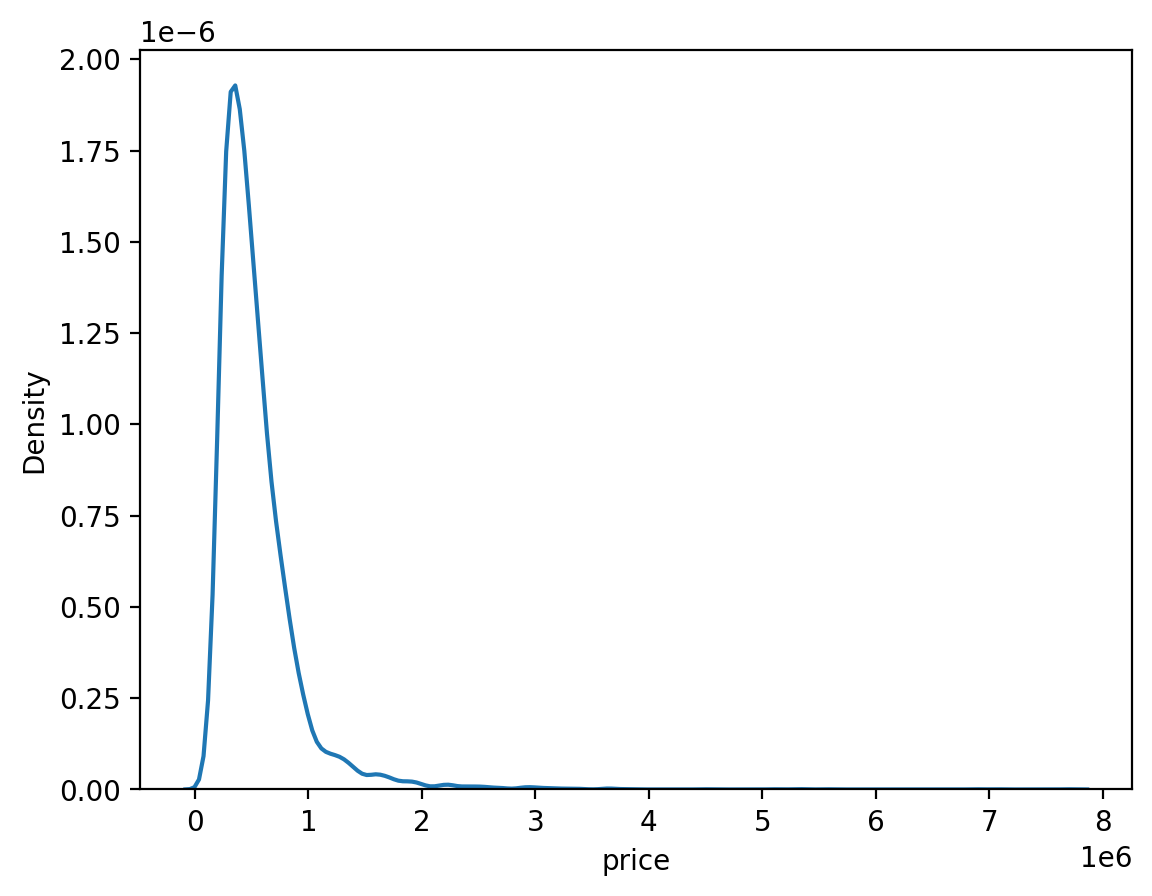

In [70]:
# 분포 확인
#seaborn의 `kdeplot`을 활용해 `y`의 분포를 확인

sns.kdeplot(y)
plt.show()

In [71]:
# 왼쪽으로 치우친 y 데이터를 확인.
# 로그 스케일링을 통해 고르게 변환해준다.
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

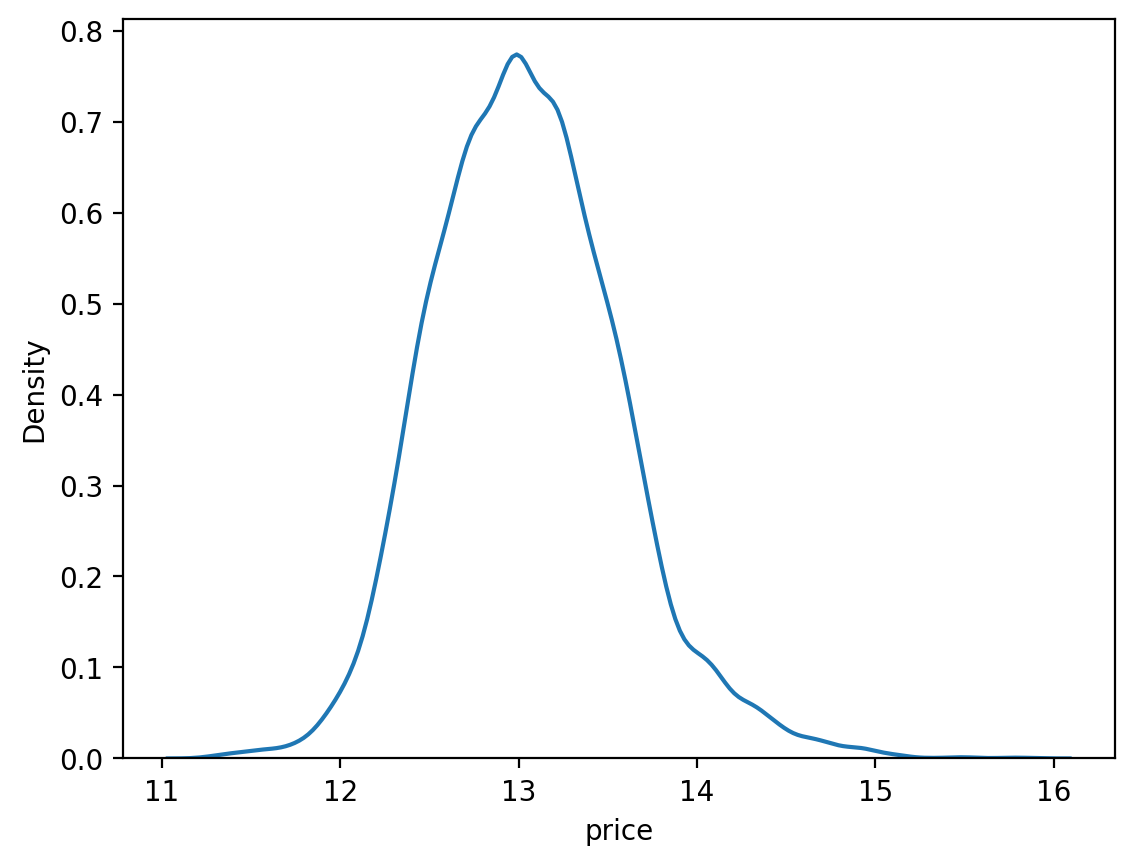

In [72]:
# 로그 스케일링 후 y 분포 확인
sns.kdeplot(y)
plt.show()

In [14]:
# 전처리 완료 후 자료형이 모두 int 또는 float임을 확인할 수 있다.
# 즉 학습할 준비 완료
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   grade          15035 non-null  int64  
 9   sqft_above     15035 non-null  int64  
 10  sqft_basement  15035 non-null  int64  
 11  yr_renovated   15035 non-null  int64  
 12  zipcode        15035 non-null  int64  
 13  lat            15035 non-null  float64
 14  sqft_living15  15035 non-null  int64  
 15  sqft_lot15     15035 non-null  int64  
dtypes: float64(3), int64(13)
memory usage: 1.8 MB


### 학습을 위한 모델 준비

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

print('split과 RMSE 계산을 위한 라이브러리 준비')

split과 RMSE 계산을 위한 라이브러리 준비


In [16]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

# 로그 스케일링을 되돌리기 위해 `np.sxpm1()`을 취해야 한다


print('rmse 함수 준비')

rmse 함수 준비


In [19]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

print('사용할 4가지 모델 준비')

사용할 4가지 모델 준비


In [20]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값.
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택.
random_state=2025        # 하지만 재현을 위해서 시드를 고정

# 모델 호출
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

# 리스트에 모델 넣어두기
models = [gboost, xgboost, lightgbm, rdforest]

print('models에 모델 4가지 준비 완료')

models에 모델 4가지 준비 완료


In [21]:
# 모델의 이름을 알려주는 클래스의 name 속성
lightgbm.__class__.__name__

'LGBMRegressor'

In [22]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리
    # random_state를 사용하여 고정하고 train과 test 셋의 비율은 8:2로 한다.
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)


    # 모델 학습
    model.fit(X_train, y_train)

    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)

    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

df

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1925
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 16
[LightGBM] [Info] Start training from score 13.047062


{'GradientBoostingRegressor': np.float64(147522.26976137154),
 'XGBRegressor': np.float64(148589.10661841504),
 'LGBMRegressor': np.float64(145865.24372231797),
 'RandomForestRegressor': np.float64(153548.62122456235)}

**4가지 모델의 rmse를 `score_df`에 저장해두었다.**

{'GradientBoostingRegressor': np.float64(148196.2196251954),

 'XGBRegressor': np.float64(137073.91727764634),
 
 'LGBMRegressor': np.float64(140783.2961141863),
 
 'RandomForestRegressor': np.float64(154441.5117464055)}

---

진행했던 모델 준비 과정("함수 준비 -> 모델 준비 -> 학습" )을

아래와 같이 **하나의 함수**로 정의할 수 있다.

In [23]:
def get_scores(models, train, y):
    df = {}

    for model in models:
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

In [24]:
score_df

RMSE
RandomForestRegressor      153548.621225
XGBRegressor               148589.106618
GradientBoostingRegressor  147522.269761
LGBMRegressor              145865.243722

### 하이퍼 파라미터 튜닝 (with 그리드 탐색)

In [25]:
from sklearn.model_selection import GridSearchCV

print('라이브러리 준비')

라이브러리 준비


In [26]:
# 사용 예제
# xgboost 관련 하이퍼 파라미터 준비

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

In [27]:
# 모델 준비
model = LGBMRegressor(random_state=random_state)

print('얍💢')

얍💢


In [28]:
# `param_grid` 내의 모든 하이퍼 파라미터의 조합에 대해 실험 진행

grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

# 경우의 수 20개 : n_estimator(2) * max_depth(2) * cross validation(5) = 20

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 16
[LightGBM] [Info] Start training from score 13.050187
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2025), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [29]:
# 4가지 조합에 대한 실험 결과를 저장
grid_model.cv_results_

{'mean_fit_time': array([0.44926629, 0.40093112, 0.80959673, 1.04969931]),
 'std_fit_time': array([0.07064478, 0.06131221, 0.12692867, 0.04357787]),
 'mean_score_time': array([0.03017874, 0.0335454 , 0.05445914, 0.06435781]),
 'std_score_time': array([0.00986583, 0.00883081, 0.00790224, 0.02575157]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value=999999),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value=999999),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.0756974 , -0.05624069, -0.03187506, -0.02999311]),
 'split1_test_score': array([-0.07666447, -0.05860807, -0.03421304, -0.03251661]),
 'split2_test_score': array([-0.07354904, -0.05632832, -0.0336634 , -0.03174766]),
 'spl

원하는 값만 정제해서 확인해야 한다.

우리가 관심있는 정보는 "어떤 파라미터 조합일 떄 점수가 어떻게 나오는가"이며,

파라미터 조합은 `params`에 저장되어 있고,

각 테스트 점수는 `mean_test_score`에 저장할 것이다.

In [30]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [31]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339447, -0.05560312, -0.03245105, -0.03067732])

In [32]:
# params와 score를 이용해서 최적의 성능을 내는 하이퍼 파라미터 조합을 찾는다.

results = pd.DataFrame(params)
results['score'] = score

results

max_depth  n_estimators     score
0          1            50 -0.073394
1          1           100 -0.055603
2         10            50 -0.032451
3         10           100 -0.030677

In [33]:
# rmse 점수도 results에 추가한다.

results['RMSE'] = np.sqrt(-1 * results['score'])
results

max_depth  n_estimators     score      RMSE
0          1            50 -0.073394  0.270914
1          1           100 -0.055603  0.235803
2         10            50 -0.032451  0.180142
3         10           100 -0.030677  0.175149

In [34]:
# price에 취했던 log를 되돌리고,
# 그에 따라 이름도 RMSLE 로 바꾼다

results = results.rename(columns={'RMSE': 'RMSLE'})
results

max_depth  n_estimators     score     RMSLE
0          1            50 -0.073394  0.270914
1          1           100 -0.055603  0.235803
2         10            50 -0.032451  0.180142
3         10           100 -0.030677  0.175149

In [35]:
# 위의 표를 `RMSLE`가 낮은 순서대로 정렬한다.

results = results.sort_values('RMSLE')
results

max_depth  n_estimators     score     RMSLE
3         10           100 -0.030677  0.175149
2         10            50 -0.032451  0.180142
1          1           100 -0.055603  0.235803
0          1            50 -0.073394  0.270914

지금까지 진행한 그리드 탐색 과정을 진행할 수 있는 하나의 함수를 정의한다.

`my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 함수를 표현해보자.

1. GridSearchCV 모델로 `model`을 초기화합니다.
2. 모델을 fitting 합니다.
3. params, score에 각 조합에 대한 결과를 저장합니다.
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.


In [36]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [37]:
results

max_depth  n_estimators     score     RMSLE
3         10           100 -0.030677  0.175149
2         10            50 -0.032451  0.180142
1          1           100 -0.055603  0.235803
0          1            50 -0.073394  0.270914

## 제출하기

In [38]:
# 파라미터 추가
param_grid = {
    'n_estimators': [100, 300, 500, 800],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [-1, 5, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 36 candidates, totalling 180 fits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

learning_rate  max_depth  n_estimators     score     RMSLE
22           0.05         10           500 -0.029818  0.172679
14           0.05         -1           500 -0.029992  0.173181
21           0.05         10           300 -0.030003  0.173214
23           0.05         10           800 -0.030027  0.173283
19           0.05          5           800 -0.030044  0.173332
25           0.10         -1           300 -0.030051  0.173354
13           0.05         -1           300 -0.030052  0.173355
29           0.10          5           300 -0.030163  0.173674
18           0.05          5           500 -0.030164  0.173678
15           0.05         -1           800 -0.030199  0.173780
33           0.10         10           300 -0.030208  0.173804
30           0.10          5           500 -0.030253  0.173934
24           0.10         -1           100 -0.030489  0.174612
26           0.10         -1           500 -0.030515  0.174686
34           0.10         10           500 -0.030562  0.174819
31           0.10          5           800 -0.030568  0.174837
3            0.01         -1           800 -0.030589  0.174897
32           0.10         10           100 -0.030677  0.175149
11           0.01         10           800 -0.030685  0.175173
17           0.05          5           300 -0.030697  0.175206
35           0.10         10           800 -0.031043  0.176191
27           0.10         -1           800 -0.031057  0.176230
28           0.10          5           100 -0.031864  0.178505
2            0.01         -1           500 -0.032231  0.179530
10           0.01         10           500 -0.032290  0.179693
12           0.05         -1           100 -0.032303  0.179730
20           0.05         10           100 -0.032355  0.179874
7            0.01          5           800 -0.032439  0.180109
6            0.01          5           500 -0.034939  0.186921
16           0.05          5           100 -0.034997  0.187074
1            0.01         -1           300 -0.037779  0.194369
9            0.01         10           300 -0.037814  0.194459
5            0.01          5           300 -0.040635  0.201581
0            0.01         -1           100 -0.084412  0.290537
8            0.01         10           100 -0.084412  0.290537
4            0.01          5           100 -0.087124  0.295168

### 가장 좋은 조합:

- learning_rate=0.05
-  max_depth=10
-  n_estimators=500

In [39]:
# 가장 좋은 조합으로 모델 준비
model = LGBMRegressor(learning_rate=0.05, max_depth=10, n_estimators=500, random_state=random_state)

# 학습하기
model.fit(train, y)

# test로 예측하기
prediction = model.predict(test)
prediction

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1960
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 16
[LightGBM] [Info] Start training from score 13.048122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

array([13.13809313, 12.97649029, 14.11195695, ..., 13.02297314,
       12.5608426 , 12.98244106], shape=(6468,))

In [40]:
# log 취했던 스케일 돌리기
prediction = np.expm1(prediction)
prediction

array([ 507926.05728564,  432132.6913655 , 1345069.45138592, ...,
        452693.6593166 ,  285169.52196937,  434711.88608474],
      shape=(6468,))

In [41]:
# sample_submission.csv 가져오기

data_dir = os.path.join(os.getenv('HOME'), 'work/kaggle_kakr_housing/data')

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

id   price
0  15035  100000
1  15036  100000
2  15037  100000
3  15038  100000
4  15039  100000

In [42]:
# 우리 모델이 예측한 값을 덮어씌우기
submission['price'] = prediction
submission.head()

id         price
0  15035  5.079261e+05
1  15036  4.321327e+05
2  15037  1.345069e+06
3  15038  3.593259e+05
4  15039  3.171599e+05

In [43]:
# 덮어씌운 csv를 새로운 csv로 저장하기

submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.172679')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/home/jovyan/work/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.172679.csv


---
위 과정을 수행하는 `save_submission(model, train, y, test, model_name, rmsle)` 함수를 구현하기
1. 모델을 `train`, `y`로 학습시킵니다.
2. `test`에 대해 예측합니다.
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.


In [44]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.path.join(os.getenv('HOME'), 'work/kaggle_kakr_housing/data')
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [44]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.172679')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1960
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 16
[LightGBM] [Info] Start training from score 13.048122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

## 다른 모델로 반복하기

In [45]:
# gboost로 시도하기

param_grid = {
    'n_estimators': [100, 300,500],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.05, 0.1]
}

model = GradientBoostingRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


learning_rate  max_depth  n_estimators     score     RMSLE
26           0.10          4           500 -0.030406  0.174373
17           0.05          4           500 -0.030580  0.174871
25           0.10          4           300 -0.030686  0.175173
23           0.10          3           500 -0.030869  0.175695
16           0.05          4           300 -0.031835  0.178423
22           0.10          3           300 -0.031841  0.178441
14           0.05          3           500 -0.032325  0.179792
20           0.10          2           500 -0.032744  0.180952
24           0.10          4           100 -0.033619  0.183355
13           0.05          3           300 -0.034524  0.185805
19           0.10          2           300 -0.034778  0.186489
11           0.05          2           500 -0.035915  0.189512
21           0.10          3           100 -0.036873  0.192024
15           0.05          4           100 -0.037433  0.193477
8            0.01          4           500 -0.037529  0.193725
10           0.05          2           300 -0.039478  0.198691
18           0.10          2           100 -0.043090  0.207580
5            0.01          3           500 -0.043121  0.207657
12           0.05          3           100 -0.043148  0.207721
7            0.01          4           300 -0.044674  0.211361
9            0.05          2           100 -0.051384  0.226681
2            0.01          2           500 -0.051541  0.227026
4            0.01          3           300 -0.052339  0.228777
1            0.01          2           300 -0.066018  0.256939
6            0.01          4           100 -0.093198  0.305284
3            0.01          3           100 -0.103288  0.321384
0            0.01          2           100 -0.123390  0.351269

In [46]:
# 저장하기
model = GradientBoostingRegressor(learning_rate=0.1, max_depth=4, n_estimators=500, random_state=random_state)
save_submission(model, train, y, test, 'gboost', rmsle='0.174373')

/home/jovyan/work/kaggle_kakr_housing/data/submission_gboost_RMSLE_0.174373.csv saved!


In [47]:
# xgboost 로 시도하기
param_grid = {
    'n_estimators': [300, 500, 800],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1]
}

model = XGBRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


learning_rate  max_depth  n_estimators     score     RMSLE
14           0.05          5           800 -0.030100  0.173492
13           0.05          5           500 -0.030156  0.173654
20           0.10          3           800 -0.030219  0.173838
21           0.10          5           300 -0.030221  0.173841
22           0.10          5           500 -0.030332  0.174162
16           0.05          7           500 -0.030442  0.174477
15           0.05          7           300 -0.030526  0.174718
19           0.10          3           500 -0.030620  0.174987
17           0.05          7           800 -0.030661  0.175102
23           0.10          5           800 -0.030730  0.175301
24           0.10          7           300 -0.030775  0.175429
12           0.05          5           300 -0.030790  0.175470
11           0.05          3           800 -0.030817  0.175547
8            0.01          7           800 -0.031023  0.176135
25           0.10          7           500 -0.031176  0.176568
18           0.10          3           300 -0.031582  0.177715
26           0.10          7           800 -0.031591  0.177738
10           0.05          3           500 -0.032083  0.179117
7            0.01          7           500 -0.032450  0.180138
5            0.01          5           800 -0.032601  0.180558
9            0.05          3           300 -0.034357  0.185356
4            0.01          5           500 -0.035053  0.187223
6            0.01          7           300 -0.036280  0.190473
2            0.01          3           800 -0.038378  0.195903
3            0.01          5           300 -0.040712  0.201772
1            0.01          3           500 -0.043374  0.208263
0            0.01          3           300 -0.052516  0.229163

In [48]:
# 저장하기
model = XGBRegressor(learning_rate=0.05, max_depth=5, n_estimators=800, random_state=random_state)
save_submission(model, train, y, test, 'xgboost', rmsle='0.173492')

/home/jovyan/work/kaggle_kakr_housing/data/submission_xgboost_RMSLE_0.173492.csv saved!


In [ ]:
# rdforest 로 시도하기
param_grid = {
    'n_estimators': [200, 500, 1000],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

model = RandomForestRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


In [ ]:
# 저장하기
model = RandomForestRegressor(n_estimators=, max_depth=, min_samples_split=, min_samples_leaf=, max_features=, random_state=random_state)
save_submission(model, train, y, test, 'xgboost', rmsle='0.161672')

## Feature 전처리 다시 시도

110,000점 아래로 내려가지 않아서, 다중공선성을 줄이는 방식을 도입하기로 했다.

In [45]:
print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'grade', 'sqft_above', 'sqft_basement',
       'yr_renovated', 'zipcode', 'lat', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [47]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def reduce_multicollinearity(
        X: pd.DataFrame,
        y: pd.Series,
        target_corr_thr: float = 0.05,
        feat_corr_thr:   float = 0.90,
        vif_thr:         float = 10.0,
        verbose: bool = True) -> pd.DataFrame:
    """
    1) |corr(feature, y)| < target_corr_thr  → 제거
    2) |corr(f_i, f_j)|  > feat_corr_thr     → 유사 피처 중 하나 제거
    3) VIF(f_i)         > vif_thr            → 반복적으로 제거
    반환: 공선성 완화된 X
    """
    X_clean = X.copy()

    # ---------- 1. 목표 변수와 상관계수 ----------
    corr_to_y = X_clean.corrwith(y).abs()
    low_corr = corr_to_y[corr_to_y < target_corr_thr].index
    if verbose and len(low_corr):
        print(f"◆ y와 |corr| < {target_corr_thr} → 제거:", list(low_corr))
    X_clean.drop(columns=low_corr, inplace=True)

    # ---------- 2. 피처끼리 상관계수 ----------
    upper = X_clean.corr().abs().where(
        np.triu(np.ones(len(X_clean.columns)), k=1).astype(bool))
    high_corr = [c for c in upper.columns if any(upper[c] > feat_corr_thr)]
    if verbose and len(high_corr):
        print(f"◆ 피처끼리 |corr| > {feat_corr_thr} → 제거:", high_corr)
    X_clean.drop(columns=high_corr, inplace=True)

    # ---------- 3. VIF ----------
    def _vif(df):
        return pd.Series([variance_inflation_factor(df.values, i)
                          for i in range(df.shape[1])],
                         index=df.columns)

    while True:
        vifs = _vif(X_clean)
        max_vif = vifs.max()
        if max_vif < vif_thr:
            break
        col_drop = vifs.idxmax()
        if verbose:
            print(f"◆ VIF {max_vif:.2f} > {vif_thr} → {col_drop} 제거")
        X_clean.drop(columns=[col_drop], inplace=True)

    if verbose:
        print("✅ 최종 컬럼:", list(X_clean.columns))
        print("✅ shape:", X_clean.shape)
    return X_clean


[LightGBM] [Info] Total Bins 1953
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 16
[LightGBM] [Info] Start training from score 13.051670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=100; total time=   1.2s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1949
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 16
[LightGBM] [Info] Start training from score 13.052839
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

In [65]:
Train_2 = reduce_multicollinearity(train, y,
                                   target_corr_thr=0.05,
                                   feat_corr_thr=0.90,
                                   vif_thr=10.0)

◆ y와 |corr| < 0.05 → 제거: ['id', 'date', 'condition', 'yr_built', 'long']
◆ VIF inf > 10.0 → sqft_living 제거
◆ VIF 133488.93 > 10.0 → lat 제거
◆ VIF 135.75 > 10.0 → grade 제거
◆ VIF 25.52 > 10.0 → zipcode 제거
◆ VIF 24.68 > 10.0 → bathrooms 제거
◆ VIF 19.53 > 10.0 → sqft_living15 제거
◆ VIF 13.17 > 10.0 → bedrooms 제거
✅ 최종 컬럼: ['sqft_lot', 'floors', 'waterfront', 'view', 'sqft_above', 'sqft_basement', 'yr_renovated', 'sqft_lot15']
✅ shape: (15035, 8)


In [66]:
# 2️최종 컬럼 목록 저장
final_cols = Train_2.columns
print(Train_2.columns)

Index(['sqft_lot', 'floors', 'waterfront', 'view', 'sqft_above',
       'sqft_basement', 'yr_renovated', 'sqft_lot15'],
      dtype='object')


In [68]:
Test_2 = test[final_cols].copy()
print(Test_2.columns)

Index(['sqft_lot', 'floors', 'waterfront', 'view', 'sqft_above',
       'sqft_basement', 'yr_renovated', 'sqft_lot15'],
      dtype='object')


In [73]:
# 파라미터 추가
param_grid = {
    'n_estimators': [100, 300, 500, 800],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [1, 5, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, Train_2, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1056
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 8
[LightGBM] [Info] Start training from score 13.051670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

learning_rate  max_depth  n_estimators     score     RMSLE
11           0.01         10           800 -0.111760  0.334305
20           0.05         10           100 -0.111967  0.334614
10           0.01         10           500 -0.111975  0.334627
32           0.10         10           100 -0.112103  0.334818
28           0.10          5           100 -0.112352  0.335190
21           0.05         10           300 -0.112389  0.335245
17           0.05          5           300 -0.112450  0.335335
7            0.01          5           800 -0.112465  0.335359
18           0.05          5           500 -0.112906  0.336014
6            0.01          5           500 -0.113107  0.336314
16           0.05          5           100 -0.113151  0.336379
29           0.10          5           300 -0.113297  0.336597
22           0.05         10           500 -0.113801  0.337344
9            0.01         10           300 -0.113952  0.337568
19           0.05          5           800 -0.114183  0.337909
33           0.10         10           300 -0.114940  0.339029
30           0.10          5           500 -0.115157  0.339348
5            0.01          5           300 -0.115674  0.340109
23           0.05         10           800 -0.116005  0.340595
31           0.10          5           800 -0.117672  0.343034
34           0.10         10           500 -0.118123  0.343690
27           0.10          1           800 -0.119163  0.345200
26           0.10          1           500 -0.119461  0.345632
15           0.05          1           800 -0.119723  0.346010
25           0.10          1           300 -0.120233  0.346746
14           0.05          1           500 -0.120815  0.347585
35           0.10         10           800 -0.122668  0.350240
13           0.05          1           300 -0.123577  0.351535
24           0.10          1           100 -0.128089  0.357896
3            0.01          1           800 -0.133003  0.364696
8            0.01         10           100 -0.143202  0.378420
4            0.01          5           100 -0.144453  0.380070
12           0.05          1           100 -0.144641  0.380317
2            0.01          1           500 -0.145318  0.381206
1            0.01          1           300 -0.163632  0.404514
0            0.01          1           100 -0.211183  0.459547


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

In [54]:
# 저장하기
model = LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=800, random_state=random_state)
save_submission(model, train, y, test, 'xgboost_2', rmsle='0.335760')

/home/jovyan/work/kaggle_kakr_housing/data/submission_xgboost_2_RMSLE_0.335760.csv saved!
